In [1]:
import warnings
warnings.filterwarnings('ignore')

## 1. Clean and preprocess data

In [2]:
from v2_clean import remove_221_rows, dropping_no_betting_data, josh_features, fill_f_pm_01m, class_or_rating_average, oli_features
from v2_preprocessor import preprocess_features_v2
import pandas as pd

data  = pd.read_csv("raw_data/raw_data_v2.2.csv")

data_cleaned = remove_221_rows(data)
data_cleaned = dropping_no_betting_data(data_cleaned)
data_cleaned = josh_features(data_cleaned)
data_cleaned = class_or_rating_average(data_cleaned)
data_cleaned = oli_features(data_cleaned)
data_cleaned = fill_f_pm_01m(data_cleaned)

preprocessed_data = preprocess_features_v2(data_cleaned)

preprocessed_data.to_csv("raw_data/data_cleaned_and_preprocessed.csv", index=False)

data = pd.read_csv("raw_data/data_cleaned_and_preprocessed.csv")
data.sort_values(by='f_ko')
data = data.reset_index(drop=True)

first 221 rows removed. New shape = (118354, 116)
Cleaned up missing odds. New shape = (118093, 116)
Added Josh features. New shape = (118093, 123)
Added Oli features 2/4. New shape = (118093, 125)
Added Oli features 4/4. New shape = (118093, 127)
number of columns:  128
✅ DROPPED IRRELEVANT COLUMNS
✅ DROPPED ROWS WITH NULL VALUES
✅ WHITESPACE STRIPPED FROM 'f_track'
✅ ODDS CONVERTED TO PROBABILITY (1/ODDS)
✅ WINNERS CODED AS '1', REST '0'
✅ 'f_ko' CONVERTED TO DATETIME
✅ TRACK CONDITIONS ORDINALLY ENCODED
✅ NUMERIC FEATURES MINMAX-SCALED
✅ IMPUTED 'no_headgear' for NULLS IN 'f_headgear'
✅ IMPUTED MEAN FOR NULLS IN 'f_dob' & 'f_prb_avg'
✅ IMPUTED '0' FOR NULLS IN 68 x FEATURES
✅ CAT. FEATURES OH-ENCODED (Track, Headgear, Country)
number of columns:  88
✅ COLUMN TRANSFORMER ASSEMBLED
⏳ FIT_TRANSFORMING THE PREPROCESSING PIPE...
number of columns:  164
✅ DATA PROCESSED WITH SHAPE: (117468, 164)


In [3]:
data = data[(data['f_pm_01m'] <= 30)]
data = data.reset_index(drop=True)

In [4]:
data.shape

(91841, 164)

## 2. Split data

In [5]:
data['pred_isp_prob'] = 1 / data['pred_isp']
backtest = data[['f_ko','f_id', 'id','f_horse', 'pred_isp_prob', 'f_pm_01m', 'f_pm_01m_p_back', 'linear_target', 'f_place']]

# X = data.drop(columns = ['f_place' , 'f_id', 'f_ko', 'f_pm_01m', 'f_pm_01m_p_back', 'pred_isp', 'linear_target', 'f_horse', 'id'])

X = data[['stall_position', 
          'iv_trainer_l50r', 'iv_jockey_l50r',
          'ae_trainer_l50r' ,'ae_jockey_l50r', 'pred_isp_prob', 'f_runners']]
y = data[["f_place"]]

X_train = X.iloc[:60000]
#X_val = X.iloc[30000:50000]
X_test = X.iloc[60000:]
y_train = y.iloc[:60000]
# y_val = y.iloc[30000:50000]
y_test = y.iloc[60000:]
backtest_train = backtest.iloc[:60000]
# backtest_val = backtest.iloc[30000:50000]
backtest_test = backtest.iloc[60000:]

## 3. Optimise and train XGBoost model on train data, then predict probabilities on test data

In [6]:
import xgboost as xgb
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV

# Model Creation:
def train_xgboost(X_train, y_train):
    # Parameter grid for hyperparameter tuning
    param_grid = {
        'learning_rate': [0.001, 0.01],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 300, 500],
        'colsample_bytree': [0.7, 0.9],
        'subsample': [0.7, 0.9]
    }

    # Create a basic model instance
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
    
    # Grid search
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                               scoring='precision', cv=3, verbose=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Return the best model
    return grid_search.best_estimator_

# Train the model
xgb_best_model = train_xgboost(X_train, y_train)

# Predict probabilities on test data
probabilities = xgb_best_model.predict_proba(X_test)[:, 1]  # Getting probabilities for the positive class
backtest_test['model_preds'] = probabilities
backtest_test['odds_preds'] = 1/ backtest_test['f_pm_01m']
backtest_test['pred_isp_preds'] = 1/ backtest_test['pred_isp_prob']
backtest_test['model_edge_basic'] = backtest_test['model_preds'] - backtest_test['odds_preds']

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/Users/lucasglanville/.pyenv/versions/3.10.6/envs/and_theyre_off_backend/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucasglanville/.pyenv/versions/3.10.6/envs/and_theyre_off_backend/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lucasglanville/.pyenv/versions/3.10.6/envs/and_theyre_off_backend/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavi

In [7]:
model_preds_race = backtest_test.groupby('f_id').sum().reset_index()
model_preds_race2 = model_preds_race[['f_id', 'model_preds', 'odds_preds']]
dict_odds_preds = model_preds_race2.set_index('f_id')['odds_preds'].to_dict()
dict_race_preds = model_preds_race2.set_index('f_id')['model_preds'].to_dict()
backtest_test['race_model_preds'] = backtest_test['f_id'].map(dict_race_preds)
backtest_test['race_odds_preds'] = backtest_test['f_id'].map(dict_odds_preds)
backtest_test['model_preds_scaled'] = (backtest_test['model_preds'] / backtest_test['race_model_preds']) * 0.96
backtest_test['model_edge_basic_scaled'] = backtest_test['model_preds_scaled'] - backtest_test['odds_preds']

## 4. Check model predictions

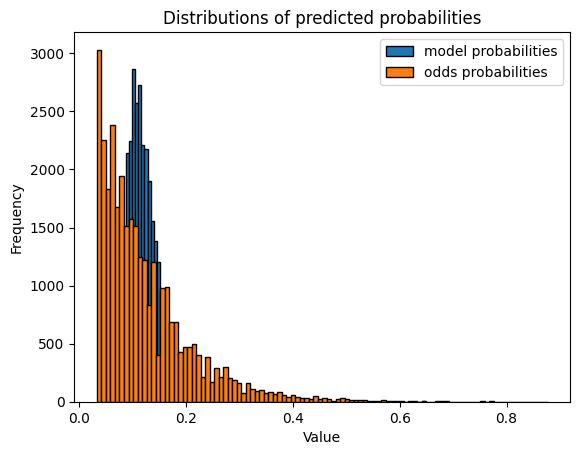

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Look at distributions of preds
plt.hist(backtest_test['model_preds_scaled'], bins=100, edgecolor='black', label='model probabilities')
plt.hist(backtest_test['odds_preds'], bins=100, edgecolor='black', label='odds probabilities')
plt.title("Distributions of predicted probabilities")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

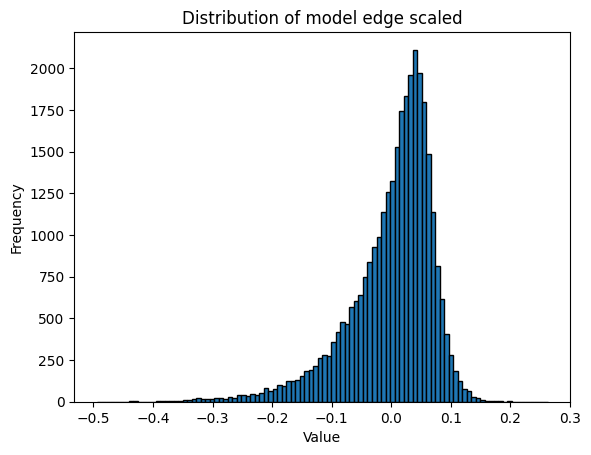

In [9]:
# Look at distribution of model edge
plt.hist(backtest_test['model_edge_basic_scaled'], bins=100, edgecolor='black')
plt.title("Distribution of model edge scaled")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

## 5. Backtesting: Is this model profitable?

In [10]:
# Create dataframes of horses above specific model edge thresholds

horses_above_3_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.03]
horses_above_4_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.04]
horses_above_5_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.05]
horses_above_6_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.06]
horses_above_7_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.07]
horses_above_8_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.08]
horses_above_9_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.09]
horses_above_10_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.1]
horses_above_11_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.11]
horses_above_12_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.12]
horses_above_13_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.13]
horses_above_14_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.14]
horses_above_15_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.15]
horses_above_20_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.2]
horses_above_30_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.3]
horses_above_32_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.32]
horses_above_35_threshold = backtest_test[backtest_test['model_edge_basic_scaled'] > 0.35]

In [11]:
# Calculate evolutions of profits for each threshold

df3 = horses_above_3_threshold.sort_values(by='f_ko')
df3['cumulative_profit'] = df3['f_pm_01m_p_back'].cumsum()

df4 = horses_above_4_threshold.sort_values(by='f_ko')
df4['cumulative_profit'] = df4['f_pm_01m_p_back'].cumsum()

df5 = horses_above_5_threshold.sort_values(by='f_ko')
df5['cumulative_profit'] = df5['f_pm_01m_p_back'].cumsum()

df6 = horses_above_6_threshold.sort_values(by='f_ko')
df6['cumulative_profit'] = df6['f_pm_01m_p_back'].cumsum()

df7 = horses_above_7_threshold.sort_values(by='f_ko')
df7['cumulative_profit'] = df7['f_pm_01m_p_back'].cumsum()

df8 = horses_above_8_threshold.sort_values(by='f_ko')
df8['cumulative_profit'] = df8['f_pm_01m_p_back'].cumsum()

df9 = horses_above_9_threshold.sort_values(by='f_ko')
df9['cumulative_profit'] = df9['f_pm_01m_p_back'].cumsum()

df10 = horses_above_10_threshold.sort_values(by='f_ko')
df10['cumulative_profit'] = df10['f_pm_01m_p_back'].cumsum()

df11 = horses_above_11_threshold.sort_values(by='f_ko')
df11['cumulative_profit'] = df11['f_pm_01m_p_back'].cumsum()

df12 = horses_above_12_threshold.sort_values(by='f_ko')
df12['cumulative_profit'] = df12['f_pm_01m_p_back'].cumsum()

df13 = horses_above_13_threshold.sort_values(by='f_ko')
df13['cumulative_profit'] = df13['f_pm_01m_p_back'].cumsum()

df14 = horses_above_14_threshold.sort_values(by='f_ko')
df14['cumulative_profit'] = df14['f_pm_01m_p_back'].cumsum()

df15 = horses_above_15_threshold.sort_values(by='f_ko')
df15['cumulative_profit'] = df15['f_pm_01m_p_back'].cumsum()

df20 = horses_above_20_threshold.sort_values(by='f_ko')
df20['cumulative_profit'] = df20['f_pm_01m_p_back'].cumsum()

df30 = horses_above_30_threshold.sort_values(by='f_ko')
df30['cumulative_profit'] = df30['f_pm_01m_p_back'].cumsum()

df32 = horses_above_32_threshold.sort_values(by='f_ko')
df32['cumulative_profit'] = df32['f_pm_01m_p_back'].cumsum()

df35 = horses_above_35_threshold.sort_values(by='f_ko')
df35['cumulative_profit'] = df35['f_pm_01m_p_back'].cumsum()

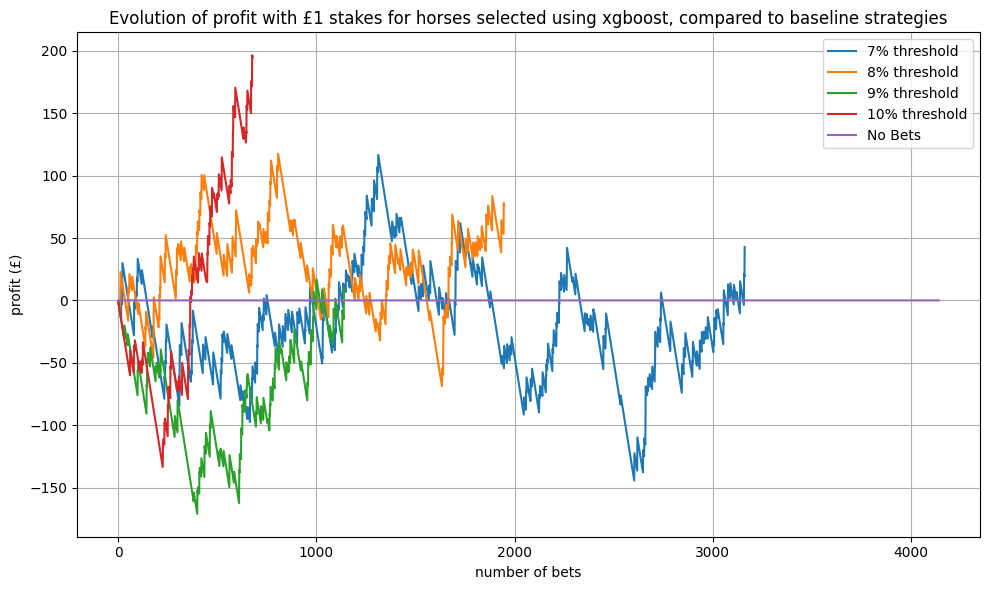

[CV 3/3] END colsample_bytree=0.7, learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.9;, score=0.000 total time=   0.7s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.001, max_depth=3, n_estimators=300, subsample=0.9;, score=0.000 total time=   2.2s
[CV 3/3] END colsample_bytree=0.7, learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.9;, score=0.500 total time=   3.6s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.7;, score=0.400 total time=   7.3s
[CV 3/3] END colsample_bytree=0.7, learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.9;, score=0.750 total time=   2.0s
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.001, max_depth=7, n_estimators=300, subsample=0.9;, score=0.800 total time=   6.1s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.9;, score=0.429 total time=  10.3s
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.01, max_dep

In [21]:
# Calculate evolution of profits for betting on favourite horse for each race
test_sorted = backtest_test.sort_values(by=['f_id', 'f_pm_01m'])
test_favorites = test_sorted.groupby('f_id').first()
test_favorites['cumulative_profit'] = test_favorites['f_pm_01m_p_back'].cumsum()
test_least_favorites = test_sorted.groupby('f_id').last()
test_least_favorites['cumulative_profit'] = test_least_favorites['f_pm_01m_p_back'].cumsum()




# Plot
plt.figure(figsize=(10,6))
plt.plot(range(1, len(df7) + 1), df7['cumulative_profit'], label='7% threshold')
plt.plot(range(1, len(df8) + 1), df8['cumulative_profit'], label='8% threshold')
plt.plot(range(1, len(df9) + 1), df9['cumulative_profit'], label='9% threshold')
plt.plot(range(1, len(df10) + 1), df10['cumulative_profit'], label='10% threshold')
# plt.plot(range(1, len(df12) + 1), df12['cumulative_profit'], label='12% threshold')
# plt.plot(range(1, len(df15) + 1), df15['cumulative_profit'], label='15% threshold')
# plt.plot(range(1, len(test_favorites) + 1), test_favorites['cumulative_profit'], label='Betting on favourites')
# plt.plot(range(1, len(test_least_favorites) + 1), test_least_favorites['cumulative_profit'], label='Betting on least favourites')
plt.plot(range(1, len(test_favorites) + 1), [0] * (len(test_favorites)), label='No Bets')
# plt.plot(range(1, len(df20) + 1), df20['cumulative_profit'], label='20% threshold')
# plt.plot(range(1, len(df30) + 1), df30['cumulative_profit'], label='30% threshold')
# plt.plot(range(1, len(df32) + 1), df32['cumulative_profit'], label='32% threshold')
# plt.plot(range(1, len(df35) + 1), df35['cumulative_profit'], label='35% threshold')
plt.title("Evolution of profit with £1 stakes for horses selected using xgboost, compared to baseline strategies")
plt.xlabel("number of bets")
plt.ylabel("profit (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
pd.DataFrame(df10['id']).to_csv('id.csv', index=False, header=False)